In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing Libraries
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras as k
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,BatchNormalization,Activation,GlobalAveragePooling2D,Dropout,Dense,MaxPooling2D,SpatialDropout2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from PIL import Image
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [3]:
# Dataset paths
original_dataset_dir = 'ck+'
train = 'ck+_train'
test = 'ck+_test'

In [4]:
# Create directories for training and testing datasets if they do not exist
os.makedirs(train, exist_ok=True)
os.makedirs(test, exist_ok=True)

In [5]:
# Define the split ratio
train_ratio = 0.8

In [6]:
# Loop through each emotion category in the original dataset
for emotion in os.listdir(original_dataset_dir):
    emotion_dir = os.path.join(original_dataset_dir, emotion)
    if os.path.isdir(emotion_dir):
        # Get a list of all the image filenames in the emotion category
        images = [f for f in os.listdir(emotion_dir) if os.path.isfile(os.path.join(emotion_dir, f))]
        
        # Randomly shuffle the list of image filenames
        np.random.shuffle(images)
        
        # Split the list of image filenames into training and testing sets
        train_size = int(len(images) * train_ratio)
        train_images = images[:train_size]
        test_images = images[train_size:]
        
        # Create directories for the emotion category in the train and test datasets
        train_emotion_dir = os.path.join(train, emotion)
        test_emotion_dir = os.path.join(test, emotion)
        os.makedirs(train_emotion_dir, exist_ok=True)
        os.makedirs(test_emotion_dir, exist_ok=True)
        
        # Copy the images into the corresponding directories
        for image in train_images:
            shutil.copy(os.path.join(emotion_dir, image), os.path.join(train_emotion_dir, image))
        for image in test_images:
            shutil.copy(os.path.join(emotion_dir, image), os.path.join(test_emotion_dir, image))

print("Dataset splitting complete")

Dataset splitting complete


In [7]:
img_size=(48,48)
bth_size=32

# Augmenting Images for training set

trdatagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.1
)

# Normalization of the pixel values for test Set
tedatagen = ImageDataGenerator(rescale=1.0/255)

In [8]:
# Reading the training data from directory

traingen= trdatagen.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale',  
    class_mode='categorical',
    shuffle=True,
    subset='training')

# Reading the testing data from directory

testgen = tedatagen.flow_from_directory(
    test,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale', 
    class_mode='categorical',
    shuffle=False
)

Found 708 images belonging to 7 classes.
Found 198 images belonging to 7 classes.


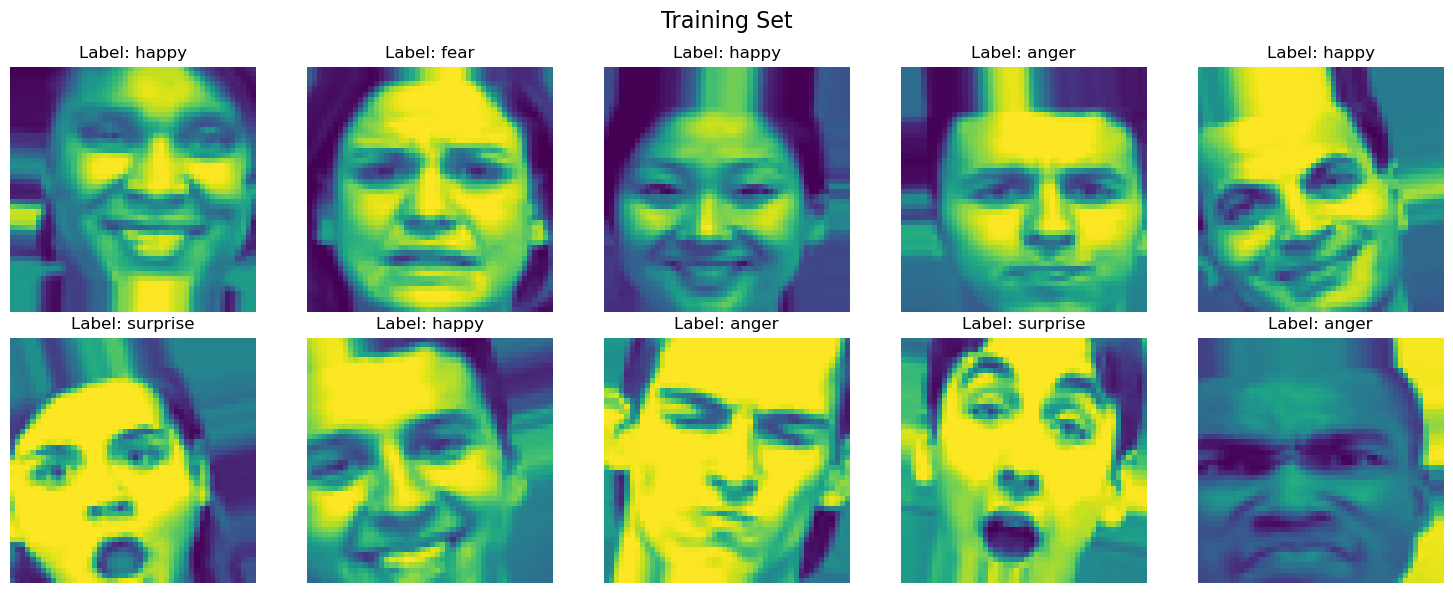

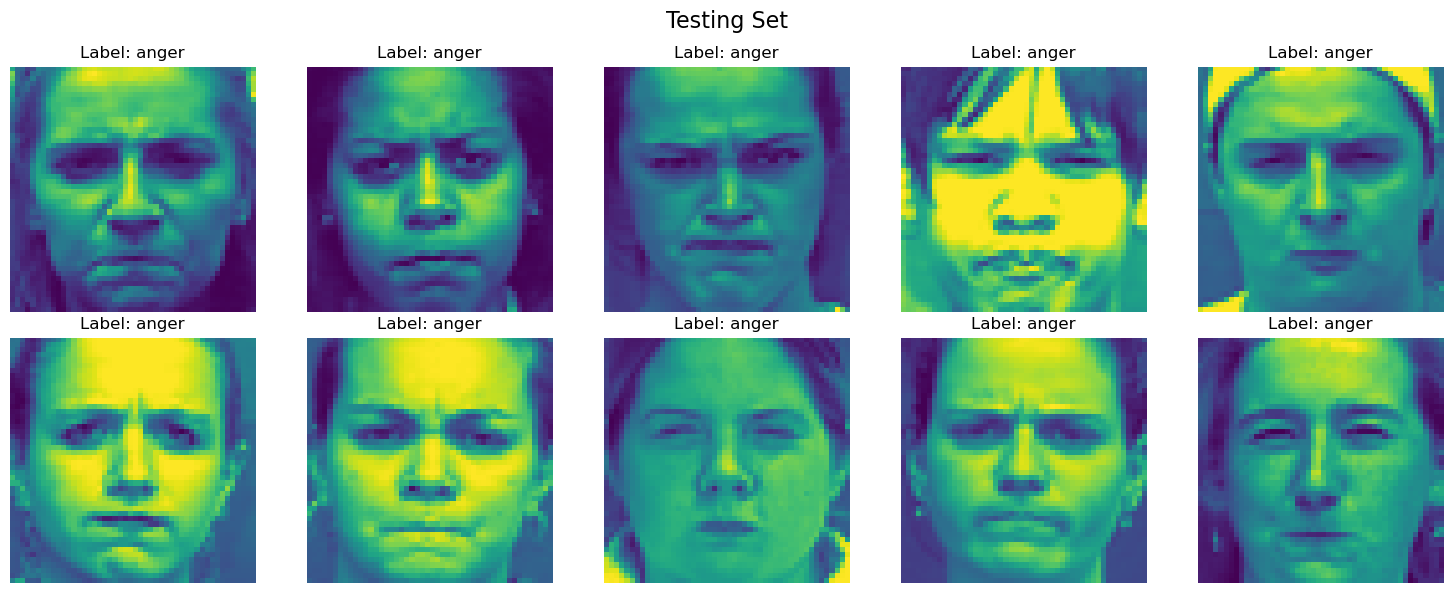

In [9]:
# Displaying the training and testing datsets (only 5 images from each dataset)

def plot_images_from_generator(generator, title, num_images=5, images_per_row=5):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for i in range(num_images):
        img = images[i]
        label = labels[i]
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {list(generator.class_indices.keys())[label.argmax()]}")
    
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_from_generator(traingen, "Training Set", num_images=10, images_per_row=5)
plot_images_from_generator(testgen, "Testing Set", num_images=10, images_per_row=5)

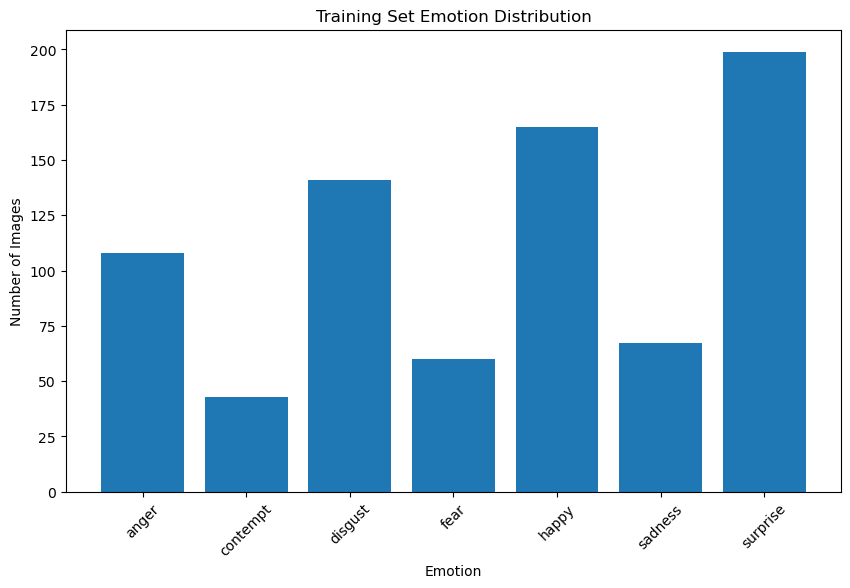

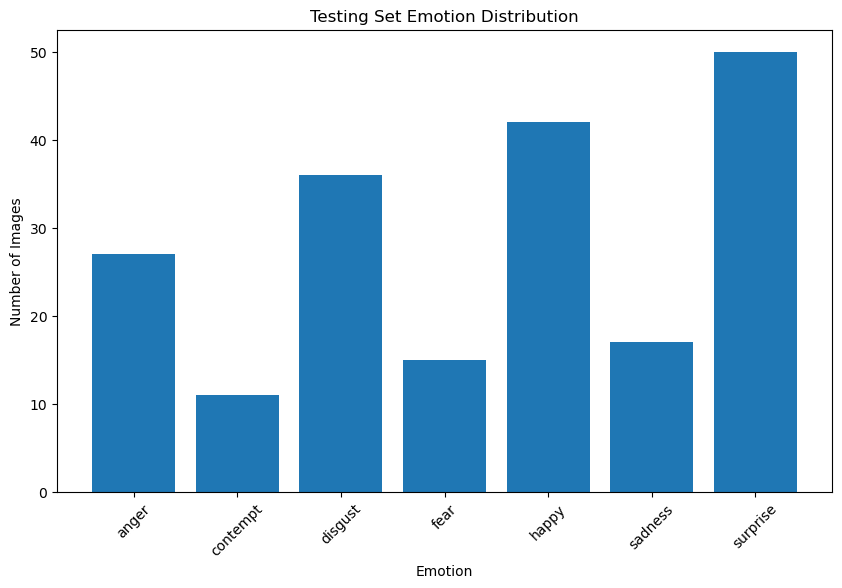

In [10]:
#class distribution

def plot_class_distribution(directory, title):
    class_names = os.listdir(directory)
    class_counts = []
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts.append(len(os.listdir(class_dir)))

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_counts)
    plt.title(title)
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution('ck+_train', "Training Set Emotion Distribution")
plot_class_distribution('ck+_test', "Testing Set Emotion Distribution")

In [11]:
# Label Map
label_map = {
    0:'anger', 
    1:'contempt',
    2:'disgust',
    3:'fear', 
    4:'happy', 
    5:'sadness', 
    6:'surprise'
}

In [12]:
# Learning rate schedule for better training control
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = Adam(learning_rate=0.001)

In [13]:
# Defining CNN model

model = Sequential()
model.add(Input(shape=(48, 48, 1)))

# Block 1
model.add(Conv2D(64, (3, 3), padding='same',
                          kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same',
                          kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(128, (3, 3), padding='same',
                          kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3), padding='same',
                          kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(256, (3, 3), padding='same',
                          kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(256, (3, 3), padding='same',
                          kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 4
model.add(Conv2D(512, (3, 3), padding='same',
                          kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(512, (3, 3), padding='same',
                          kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Increased dropout for better regularization

model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 256)    │             

 Total params: 7,057,351 (26.92 MB)

 Trainable params: 7,052,487 (26.90 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [14]:
#Implementing Early Stopping and Learning Rate Reduction
es=EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
lr=ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, verbose=1, min_delta=0.0001)

callbacks_list=[es,lr]

In [15]:
history = model.fit(
    traingen,
    epochs=100,
    validation_data=testgen,
    callbacks=callbacks_list
)

Epoch 1/100


C:\Users\RAVI RAJ\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.2159 - loss: 2.6856 - val_accuracy: 0.2071 - val_loss: 23.9951 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.2833 - loss: 2.0769 - val_accuracy: 0.1364 - val_loss: 8.3617 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.4222 - loss: 1.6790 - val_accuracy: 0.1364 - val_loss: 4.6325 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.5417 - loss: 1.3723 - val_accuracy: 0.1111 - val_loss: 5.0499 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - accuracy: 0.5707 - loss: 1.2702 - val_accuracy: 0.1616 - val_loss: 4.0112 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.6377 - loss: 1.0587 - val_accuracy: 0.3838 - val_loss: 3.3362 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.6126 - loss: 1.1258 - val

In [16]:
#Predicting
test_loss, test_accuracy = model.evaluate(testgen)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9238 - loss: 0.2222


Test Accuracy: 0.95
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        27
           1       0.90      0.82      0.86        11
           2       1.00      0.92      0.96        36
           3       0.88      1.00      0.94        15
           4       1.00      1.00      1.00        42
           5       0.85      1.00      0.92        17
           6       1.00      0.98      0.99        50

    accuracy                           0.95       198
   macro avg       0.93      0.94      0.94       198
weighted avg       0.96      0.95      0.95       198

Confusion Matrix:
[[24  0  0  0  0  3  0]
 [ 0  9  0  2  0  0  0]
 [ 3  0 33  0  0  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  0  0 42  0  0]
 [ 0  0  0  0  0 17  0]
 [ 0  1  0  0  0  0 49]] 




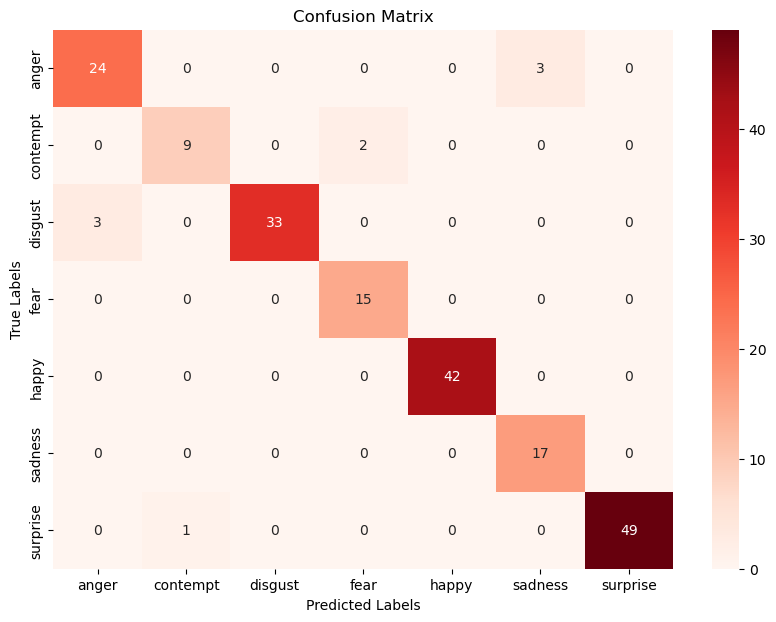

Training class indices: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'sadness': 5, 'surprise': 6}
Test class indices: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'sadness': 5, 'surprise': 6}


In [17]:
print(f"Test Accuracy: {test_accuracy:.2f}")
y_pred = np.argmax(model.predict(testgen), axis=1)
y_true = testgen.classes
print("Classification Report:")
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix,'\n\n')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
            xticklabels=list(label_map.values()), 
            yticklabels=list(label_map.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print("Training class indices:", traingen.class_indices)
print("Test class indices:", testgen.class_indices)

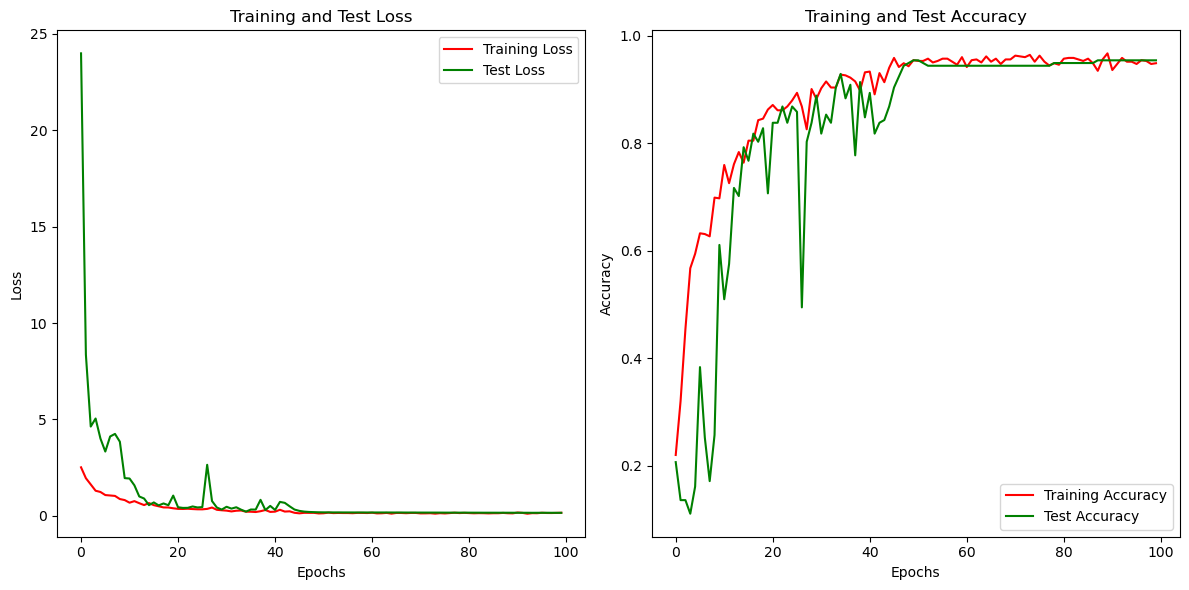

In [18]:
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Test Loss', color='green')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', color='green')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


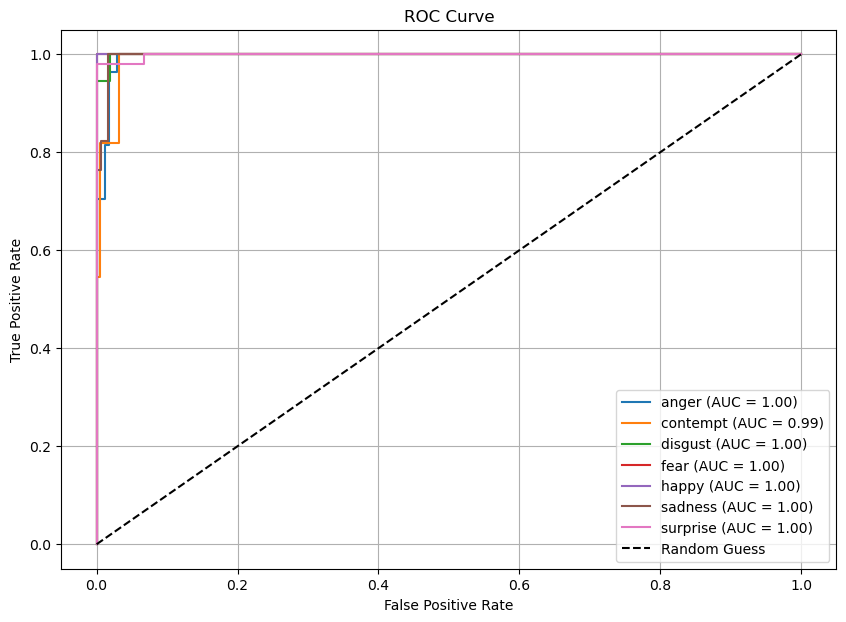

In [19]:
# Convert true labels to one-hot encoding for ROC calculations
y_true_onehot = label_binarize(y_true, classes=[0, 1, 2, 3, 4,5,6])
y_pred_prob = model.predict(testgen)

plt.figure(figsize=(10, 7))

# Plot ROC for each class
for i, class_name in label_map.items():
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()